In [398]:
# viewing neural data
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.signal import hilbert
from scipy.stats import pearsonr
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5

matplotlib.style.use('ggplot')


# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    #sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join(os.path.abspath('W:') , "earneodo", "bci_zf")
elif  'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/reposs')
    experiment_folder = os.path.join(os.path.abspath('/Volumes') , 'gentner', 'earneodo', 'bci_zf')

elif 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

elif 'passaro' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

import soundtools as st
import Kwik as oe


raw_data_folder = os.path.join(experiment_folder, 'raw_data')
ss_data_folder = os.path.join(experiment_folder, 'ss_data')


#given a chunk that contains a sine wave, find its onset
def peaks(signal, min_height=0):
    np.where(signal[1:-1]>min_height)
    peak_ind = [i for i in np.where(signal[1:-1]>min_height)[0] if signal[i]>signal[i-1] & signal[i]>signal[i+1]]
    return peak_ind

def find_onset_sine(chunk, freq=1000, f_s=30000):
    roof = int(max(chunk)*0.25)
    first_peak = peaks(chunk, min_height=roof)[0]
    
    onset = first_peak - int(f_s/(4.*freq))
    return onset

def envelope(data, window=300):
    analytic_signal = hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    w=np.ones(window, 'd')
    return np.convolve(w/w.sum(),amplitude_envelope,mode='valid')

def correlation_with_pattern(data, pattern, window, filter_func, *args, **kwargs):
    segment = envelope(filter_func(data, *args, **kwargs), window=window)
    return pearsonr(segment, pattern)[0]

def apply_repeated(s, starts, window, scalar_func, *args, **kwargs):
    # starts, window in sample units
    

    y = np.empty_like(starts)
    for i_s, start in enumerate(starts):
        a_chunk = st.Chunk(s, segment=[start, start + window])
        y[i_s] = scalar_func(a_chunk.data, *args, **kwargs)

    return y


Computer: lintu.ucsd.edu


In [2]:
#file structure
bird_id = 'z020'
sess = '2016-06-02_11-10-42_2100'
rec = 'a'
run = 1
processor = '100'

raw_file_folder = os.path.join(raw_data_folder, bird_id, sess)
raw_file_base_name = 'experiment' + str(run)

raw_file_name = raw_file_base_name + '_' + processor + '.raw.kwd'
evt_file_name = raw_file_base_name + '.kwe'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
evt_file_path = os.path.join(raw_file_folder, evt_file_name)

# open the file in read mode
raw_file = h5py.File(raw_file_path, 'r')
evt_file = h5py.File(evt_file_path, 'r')

# load it with the open-ephys api for version 2 of kiwk format

oe_file = oe.load(raw_file_path)


In [3]:
# get the sound
chan_name = "CH17"
chan_number = 17
chan_sf = oe.get_sample_rate(raw_file)

audio_slice = h5.load_table_slice(oe_file['data'], np.arange(0, oe_file['data'].shape[0]), [17])
chan_sound = st.DatSound(audio_slice[:,0], chan_sf)
# Now try to save a channel as a wav file
from scipy.io import wavfile
out_file_name = raw_file_base_name +  '_' + chan_name + 'song.wav'
wavfile.write(os.path.join(raw_file_folder, out_file_name),chan_sf, np.array(chan_sound.stream, dtype='int16'))

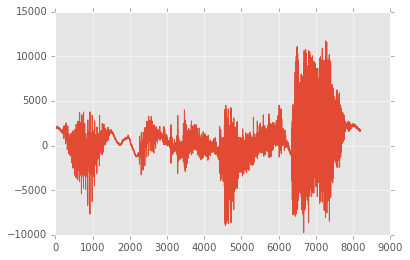

In [389]:
# grab a bout
bout_start_s = 3674.215477
bout_end_s = 3674.695533
bout_start = int(bout_start_s*chan_sf)
bout_end = bout_start + 8200
bout = st.Chunk(chan_sound, segment = [bout_start, bout_end])
plt.plot(bout.data)

In [388]:
# A filter for the sound
s_f = chan_sound.s_f
#The band where we expect most of the energy of zf song to be in
filt_lo = 7000 #Hz
filt_hi = 400 #Hz
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')
def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

band_pass_filter(bout.data, hp_b, hp_a, lp_b, lp_a)

array([ -9.0908719 , -30.28355545, -31.04915819, ...,  92.63587602,
        63.99657702,  19.64221681])

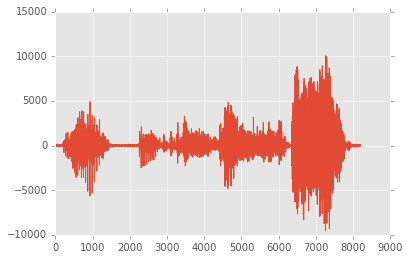

In [390]:
#save it and plot it
bout.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
plt.plot(bout.data)
#Now try to save the bout as a wav file
#from scipy.io import wavfile
#out_file_name = raw_file_base_name +  '_' + chan_name + 'song_bout.wav'
#wavfile.write(os.path.join(raw_file_folder, out_file_name), bout.sound.s_f, np.array(bout.data, dtype='int16'))

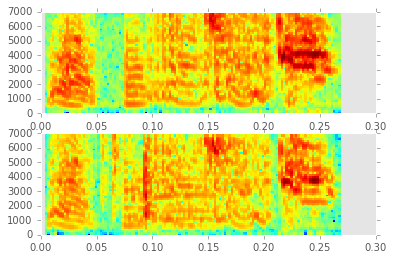

In [392]:
# compare two chunks
n_window = 256;
n_overlap = 192;
f_cut = 7000;
sigma = 1./1000.*s_f

bout2_start_s = 3675.609237
bout2_end_s = 3676.106942

bout2_start = int(bout2_start_s*chan_sf)
bout2_end = bout2_start + bout.samples
bout2 = st.Chunk(chan_sound, segment = [bout2_start, bout2_end])
bout2.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
plt.subplot(211)
f, t, Sxx = spectrogram(bout.data, s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
f, t, Sxx2 = spectrogram(bout2.data, s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
plt.pcolormesh(t, f[f<f_cut], np.log(Sxx[f<f_cut, :]))
plt.subplot(212)
plt.pcolormesh(t, f[f<f_cut], np.log(Sxx2[f<f_cut, :]))

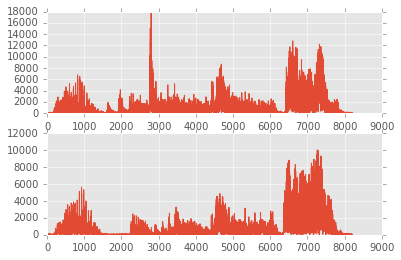

In [393]:
plt.subplot(211)
plt.plot(np.abs(bout2.data))
plt.subplot(212)
plt.plot(np.abs(bout.data))

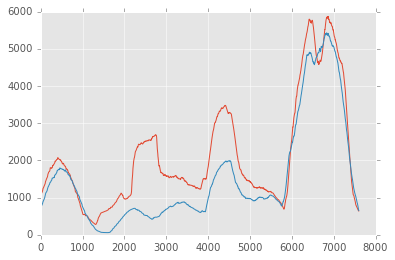

In [420]:
window_size = 600
plt.plot(envelope(bout2.data, window=window_size))
plt.plot(envelope(bout.data, window=window_size))a

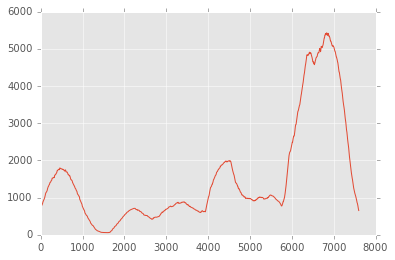

In [430]:
plt.plot(pattern)

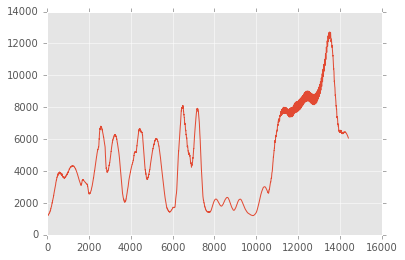

In [31]:

plt.plot(full_envelope[bout2_start:bout2_end])

In [431]:
def scalar_correlation(x, y):
    return ss.pearsonr(x,y)[0]
scalar_correlation(pattern, pattern/2)

1.0

In [432]:
env1 = pd.DataFrame(full_envelope[bout_start-300:bout_end+3000])
env2 = pd.DataFrame(full_envelope[bout2_start-3000:bout2_end+3000])

In [ ]:
full_envelope = envelope(chan_sound.stream, window=window_size)
env_full = pd.DataFrame(full_envelope)
rolled_corr = env_full.rolling(pattern.size).apply(scalar_correlation, args = (pattern, ))
corr_thresh = 0.9
# find the peaks naively
rc = rolled_corr
a = rc.values[1:-1]- rc.values[2:]
b = rc.values[1:-1]- rc.values[:-2]
c = rc.values[1:-1]


In [ ]:
corr_thresh = 0.91
max_pos = np.where((a>0) & (b>0) & (c>corr_thresh))[0]
rc.values[max_pos]

In [286]:
max_pos = max_pos[np.argsort(rc.values[max_pos], axis=0)]

In [375]:
max_pos

array([110240580, 110267024, 110344054, 163226653, 163241769, 163256932,
       163272248, 163302176, 163357081])

In [362]:
manual_starts = [3674.214226,
                 5440.417182,
                 5440.931701,
                 5441.436431,
                 5441.937063,
                 5442.929469,
                 5444.768863,
                 3677.666521]
manual_starts = np.array(np.array(manual_starts)*s_f, dtype=np.int) + pattern.size
manual_starts

array([110240528, 163226617, 163242053, 163257194, 163272213, 163301986,
       163357167, 110344097])

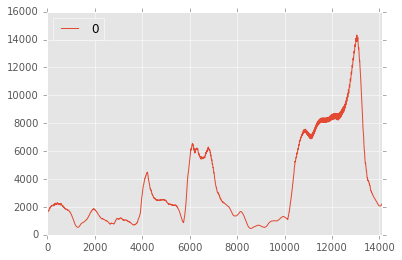

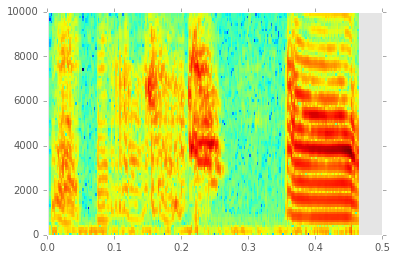

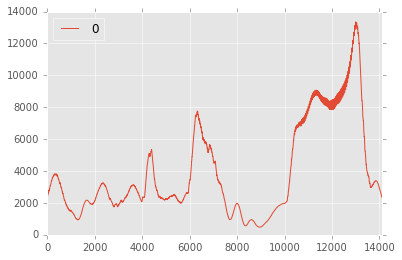

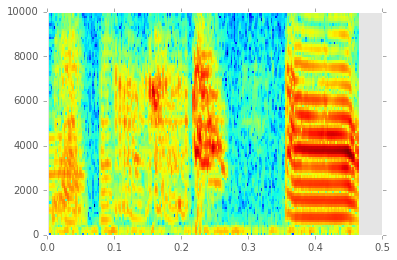

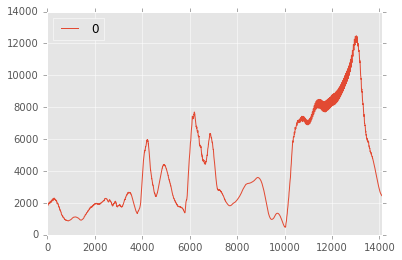

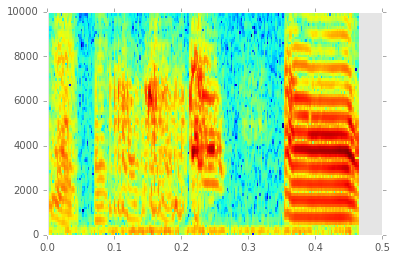

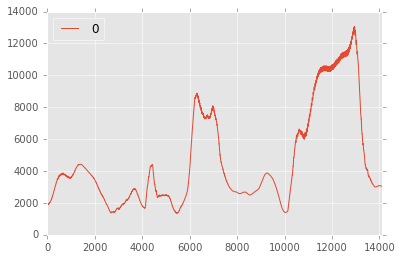

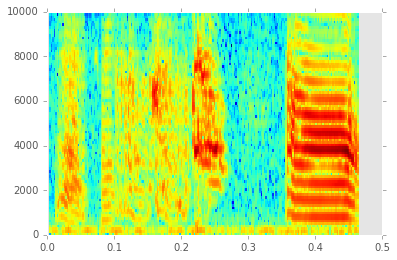

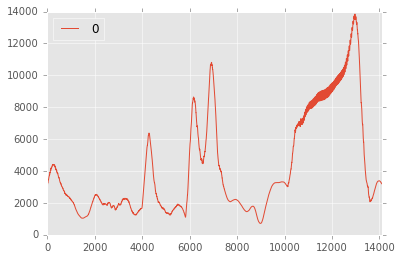

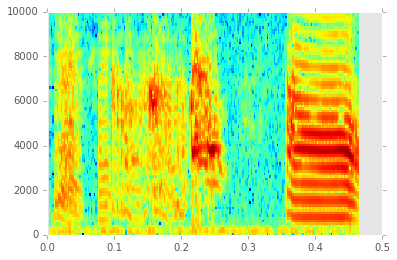

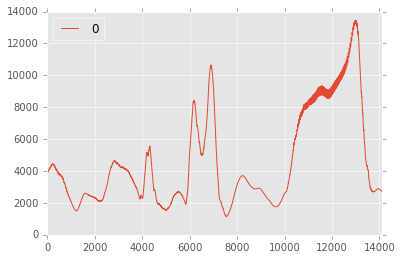

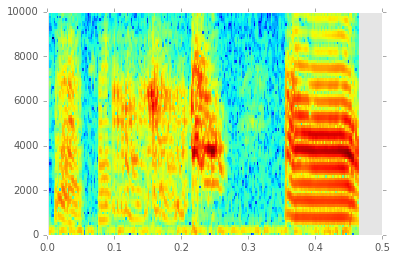

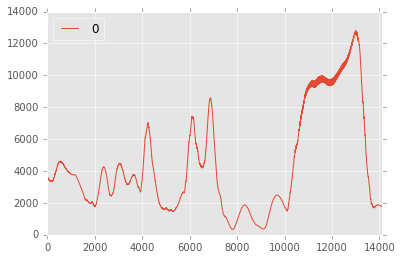

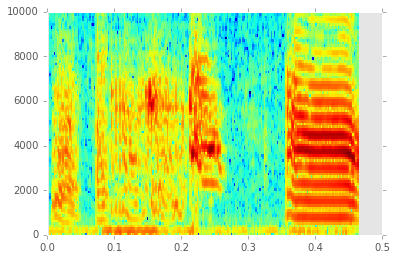

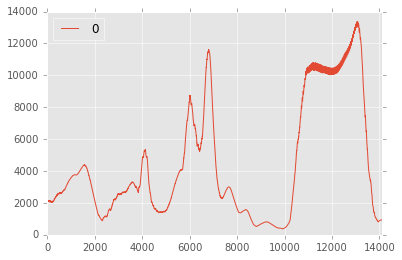

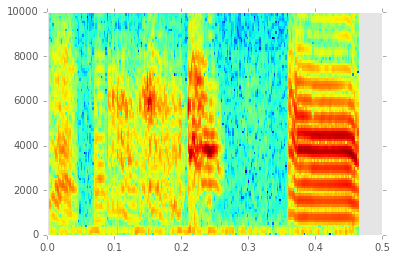

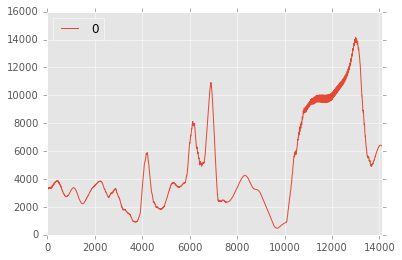

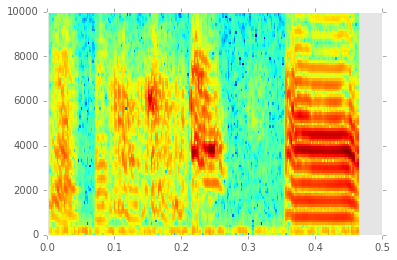

In [371]:
one_max = 0
max_pos[one_max]

for one_max in max_pos:
    motif_start = one_max - pattern.size + window
    motif_end = motif_start + pattern.size                           
    env_max = pd.DataFrame(full_envelope[motif_start: motif_end])
    env_max.plot()
    f, t, Sxx = spectrogram(chan_sound.stream[motif_start-window: motif_end-window], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
    plt.figure()
    plt.pcolormesh(t, f[f<f_cut], np.log(Sxx[f<f_cut, :]))
    

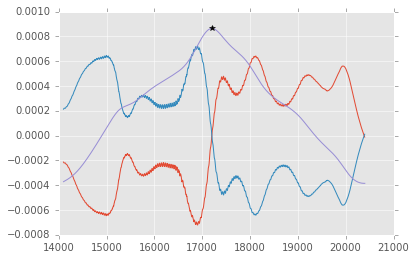

In [227]:
rc = rolled_corr
a = rc.values[1:-1]- rc.values[2:]
b = rc.values[1:-1]- rc.values[:-2]
plt.plot(a)
plt.plot(b)
plt.plot(rc.values/1000)
max_pos = np.where((a>0) & (b>0))[0]
plt.plot(max_pos, rc.values[max_pos]/1000, 'k*')